# Linear Transformations

In [2]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import reduce, partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Affine Transformations

TODO:
- use reduce to simplify, accumulate in iterate
- factor out to a module (e.g. transformations.py / linalg.py / affine.py)
- fix square figure sizes (search for ax.set_aspect(1))

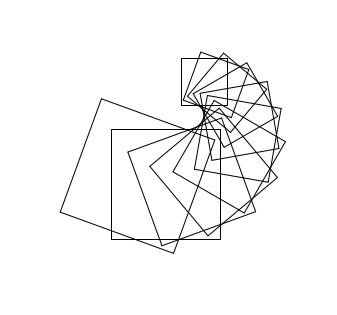

In [205]:
def matrix(a=0, b=0, c=0, d=0, e=0, f=0):
    """Return transformation matrix in homogenneous coordinates."""
    return np.matrix([[a, b, e], [c, d, f], [0, 0, 1]])

def rotation(angle):
    """Return a matrix in homogeneous coordinates
       for rotation for given angle (degrees).
    """
    c = cos(radians(angle))
    s = sin(radians(angle))
    return matrix(c, -s, s, c)

def scaling(sx, sy):
    return matrix(sx, 0, 0, sy)

def shear(k):
    return matrix(1, k, 0, 1)

def translation(tx, ty):
    return matrix(1, 0, 0, 1, tx, ty)

mirror_x = matrix(1, 0, 0, -1)
mirror_y = matrix(-1, 0, 0, 1)

def combine(*matrices):
    """Return a matrix for transformation m1->m2->m3..."""
    #return m2 * m1
    return reduce(np.matmul, reversed(matrices))
    

def apply(m, lines):
    """Apply transformation `m` to a shape(list of lines).
       Assumes each point in homogeneous coordiantes.
    """
    return [
        tuple(np.array(m.dot(point)).flatten() for point in line)
        for line in lines]

def iterate(m, shape, n=10):
    """Create image by iteratively applying a transformation,
       keeping all transformed shapes in the final image.
    """
    transformed = [shape]
    for i in range(n):
        transformed.append(apply(m, transformed[-1]))
    # Flatten shapes into a single image.
    image = [line for shape in transformed for line in shape]
    return image
        
def create_square(x=0, y=0, a=1, center=False, mark=False):
    """Create square in homogeneous coordiantes."""
    if center:
        x -= a/2
        y -= a/2
    p1 = np.array([x, y, 1])
    p2 = np.array([x+a, y, 1])
    p3 = np.array([x+a, y+a, 1])
    p4 = np.array([x, y+a, 1])
    square = [(p1, p2), (p2, p3), (p3, p4), (p4, p1)]
    if mark:
        m1 = 0.5 * p1 + 0.5 * p4
        m2 = 0.8 * p1 + 0.2 * p2
        square.append((m1, m2))
    return square

def draw(shape, axis=False):
    """Draw a shape (list of lines in homogeneus coordinates)."""
    im = VectorImage(axis=axis)
    for line in shape:
        line = tuple(p[:2] for p in line)
        im.line(line[0], line[1])
    #plt.axis('tight')

square = create_square(a=100)
m = combine(combine(rotation(-20), scaling(1.1, 1.1)), translation(5, 10))
draw(iterate(m, square, n=10))

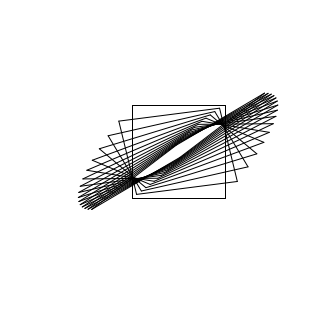

In [44]:
square = create_square(a=1, center=True)
transformation = combine(rotation(10), scaling(1.1, 0.8))
draw(iterate(transformation, square, n=15))

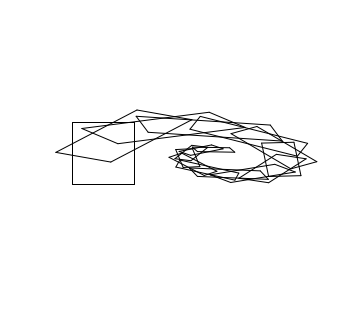

In [45]:
square = create_square(x=100, y=-50, a=100, center=False)
transformation = combine(
    shear(1.3), rotation(-10), scaling(0.9, 0.9), translation(50, 50))
draw(iterate(transformation, square, n=15))

-----

# B) Multiple Reduction Copy Machine

My mental model to help me think about the needed transformations (different from what is suggested by the coloring of circles in slides):
start with a partial fractal, shrink it (to make free space) and copy it to a few new locations (possibly with some distortions).

TODO:
- 2 more fractals (my own)
- nicer star (and fern)

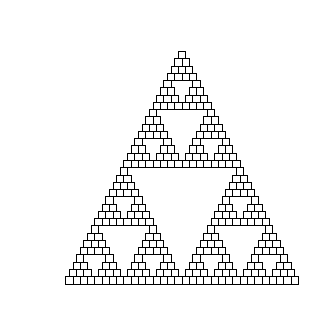

In [76]:
def mrcm(initial_shape, transformations, n=3):
    """Create a figure by iteratively applying a list
       of transformations to current shapes.
    """
    shapes = [initial_shape]
    for i in range(n):
        shapes = [
            apply(transformation, shape)
            for transformation in transformations
            for shape in shapes]
    # Flatten shapes into a single image.
    image = [line for shape in shapes for line in shape]
    draw(image, axis=False)

def sierpinski():
    shape = create_square(a=1)
    shrinking = scaling(0.5, 0.5)
    transformations = [
        shrinking,
        combine(shrinking, translation(-0.25, -0.5)),
        combine(shrinking, translation(0.25, -0.5))]
    mrcm(shape, transformations, n=5)

sierpinski()

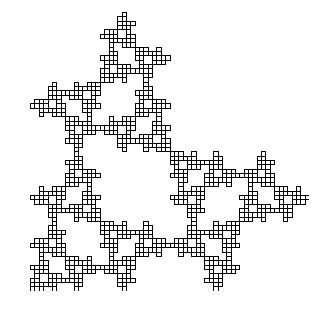

In [84]:
def sierpinski_relative1():
    shape = create_square(a=1)
    shrinking = scaling(0.5, 0.5)
    transformations = [
        combine(shrinking),
        combine(shrinking, rotation(90), translation(0.5, 0.5)),
        combine(shrinking, rotation(-90), translation(0.5, 0.5))]
    mrcm(shape, transformations, n=6)

sierpinski_relative1()

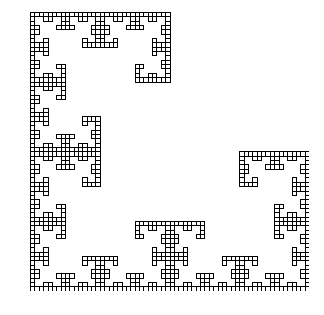

In [85]:
def sierpinski_relative2():
    shape = create_square(a=1)
    shrinking = scaling(0.5, 0.5)
    transformations = [
        combine(shrinking),
        combine(shrinking, rotation(-90), translation(0, 1)),
        combine(shrinking, rotation(90), translation(1, 0))]
    mrcm(shape, transformations, n=6)

sierpinski_relative2()

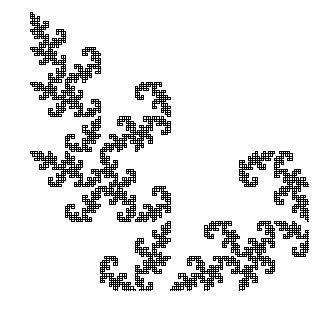

In [210]:
def sierpinski_relative3():
    shape = create_square(a=1)
    shrinking = scaling(0.5, 0.5)
    rot90 = rotation(90)
    transformations = [
        combine(shrinking, mirror_y, rot90, translation(0.5, 0.5)),
        combine(shrinking, translation(0, 0.5)),
        combine(shrinking, rot90, translation(1, 0))]
    mrcm(shape, transformations, n=7)

sierpinski_relative3()

## Star

The straightforward (ugly) way:

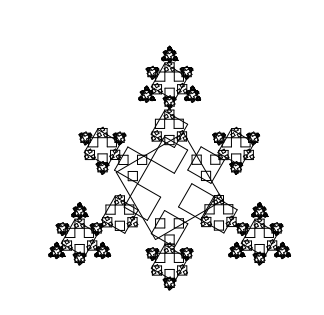

In [113]:
def star():
    shape = create_square(center=False)
    transformations = [
        matrix(0.255, 0, 0, 0.255, 0.3726, 0.6714),
        matrix(0.255, 0, 0, 0.255, 0.1146, 0.2232),
        matrix(0.255, 0, 0, 0.255, 0.6306, 0.2232),
        matrix(0.370, -0.642, 0.642, 0.370, 0.6356, -0.0061)]
    mrcm(shape, transformations, n=5)
    
star()

To improve the drawing, we only include shape that have at least one line length below threshold and we stop decomposing those shapes whose all line lengths are below a lower threshold.

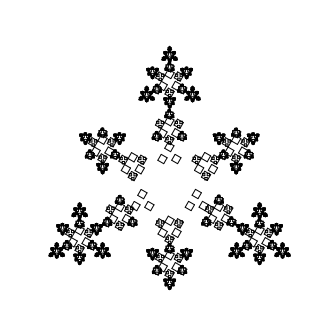

In [211]:
def max_length(shape):
    return max(length(line) for line in shape)

def min_length(shape):
    return min(length(line) for line in shape)

def length(line):
    dx = line[0][0] - line[1][0]
    dy = line[0][1] - line[1][1]
    return sqrt(dx**2 + dy**2)
    #return np.linalg.norm(line[0] - line[1])
    
def mrcm_improved(initial_shape, transformations, n=3,
                  lower_threshold=.0, upper_threshold=0.1):
    shapes = [initial_shape]
    for i in range(n):
        new_shapes = []
        for shape in shapes:
            for transformation in transformations:
                new_shape = apply(transformation, shape)
                # Drop shapes that are too small.
                if max_length(new_shape) >= lower_threshold:
                    new_shapes.append(new_shape)
        shapes = new_shapes
    # Flatten small shapes into a single image.
    small_shapes = [
        shape for shape in shapes
        if min_length(shape) < upper_threshold]
    image = [line for shape in small_shapes for line in shape]
    draw(image)

def star():
    shape = create_square(center=False)
    transformations = [
        matrix(0.255, 0, 0, 0.255, 0.3726, 0.6714),
        matrix(0.255, 0, 0, 0.255, 0.1146, 0.2232),
        matrix(0.255, 0, 0, 0.255, 0.6306, 0.2232),
        matrix(0.370, -0.642, 0.642, 0.370, 0.6356, -0.0061)]
    mrcm_improved(shape, transformations,
         n=6, lower_threshold=.001, upper_threshold=0.05)
    
star()

## Fern

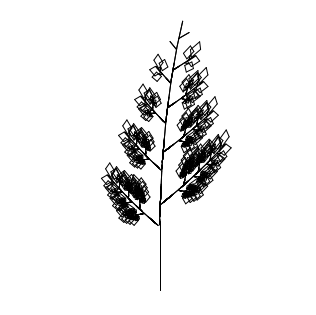

In [223]:
def fern():
    shape = create_square(center=False)
    transformations = [
        matrix(0.849, 0.037, -0.037, 0.849, 0.075, 0.183),
        matrix(0.197, -0.226, 0.226, 0.197, 0.4, 0.049),
        matrix(-0.15, 0.283, 0.26, 0.237, 0.575, 0.084),
        matrix(0, 0, 0, 0.16, 0.5, 0)]
    mrcm_improved(
        shape, transformations,
        n=6, lower_threshold=.002, upper_threshold=0.02)
    
fern()